In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(346712, 828)
(346712, 1)
validation
(56968, 828)
(56968, 1)
test
(29712, 828)
(29712, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/35 [..............................] - ETA: 51s - loss: 0.1776 - STD: 1.7755e-04 - MAE: 0.4090

 4/35 [==>...........................] - ETA: 0s - loss: 0.0621 - STD: 4.3981e-04 - MAE: 0.1943 

 5/35 [===>..........................] - ETA: 1s - loss: 0.0538 - STD: 3.9011e-04 - MAE: 0.1768

 6/35 [====>.........................] - ETA: 1s - loss: 0.0489 - STD: 3.4382e-04 - MAE: 0.1678

 7/35 [=====>........................] - ETA: 1s - loss: 0.0460 - STD: 3.0435e-04 - MAE: 0.1632

 8/35 [=====>........................] - ETA: 1s - loss: 0.0441 - STD: 2.7142e-04 - MAE: 0.1604

 9/35 [======>.......................] - ETA: 1s - loss: 0.0426 - STD: 2.4404e-04 - MAE: 0.1585

10/35 [=======>......................] - ETA: 3s - loss: 0.0417 - STD: 2.2116e-04 - MAE: 0.1570

13/35 [==========>...................] - ETA: 2s - loss: 0.0389 - STD: 1.7375e-04 - MAE: 0.1530

15/35 [===========>..................] - ETA: 2s - loss: 0.0371 - STD: 1.5411e-04 - MAE: 0.1493

16/35 [============>.................] - ETA: 1s - loss: 0.0361 - STD: 1.4662e-04 - MAE: 0.1471

17/35 [=============>................] - ETA: 1s - loss: 0.0352 - STD: 1.4035e-04 - MAE: 0.1448

18/35 [==============>...............] - ETA: 1s - loss: 0.0342 - STD: 1.3505e-04 - MAE: 0.1423

19/35 [===============>..............] - ETA: 1s - loss: 0.0332 - STD: 1.3059e-04 - MAE: 0.1395

20/35 [================>.............] - ETA: 1s - loss: 0.0322 - STD: 1.2679e-04 - MAE: 0.1366

21/35 [=================>............] - ETA: 1s - loss: 0.0312 - STD: 1.2349e-04 - MAE: 0.1338

22/35 [=================>............] - ETA: 1s - loss: 0.0302 - STD: 1.2059e-04 - MAE: 0.1313

23/35 [==================>...........] - ETA: 1s - loss: 0.0294 - STD: 1.1794e-04 - MAE: 0.1292

24/35 [===================>..........] - ETA: 0s - loss: 0.0286 - STD: 1.1546e-04 - MAE: 0.1274

25/35 [====================>.........] - ETA: 0s - loss: 0.0279 - STD: 1.1309e-04 - MAE: 0.1260

26/35 [=====================>........] - ETA: 0s - loss: 0.0274 - STD: 1.1076e-04 - MAE: 0.1250

27/35 [======================>.......] - ETA: 0s - loss: 0.0268 - STD: 1.0846e-04 - MAE: 0.1241

28/35 [=======================>......] - ETA: 0s - loss: 0.0264 - STD: 1.0618e-04 - MAE: 0.1232

29/35 [=======================>......] - ETA: 0s - loss: 0.0259 - STD: 1.0389e-04 - MAE: 0.1224

30/35 [========================>.....] - ETA: 0s - loss: 0.0255 - STD: 1.0160e-04 - MAE: 0.1215

31/35 [=========================>....] - ETA: 0s - loss: 0.0250 - STD: 9.9295e-05 - MAE: 0.1206

32/35 [==========================>...] - ETA: 0s - loss: 0.0246 - STD: 9.7007e-05 - MAE: 0.1196

33/35 [===========================>..] - ETA: 0s - loss: 0.0242 - STD: 9.4737e-05 - MAE: 0.1186

34/35 [============================>.] - ETA: 0s - loss: 0.0238 - STD: 9.2495e-05 - MAE: 0.1175

35/35 [==============================] - ETA: 0s - loss: 0.0234 - STD: 9.0295e-05 - MAE: 0.1164

35/35 [==============================] - 5s 105ms/step - loss: 0.0234 - STD: 9.0295e-05 - MAE: 0.1164 - val_loss: 0.0118 - val_STD: 1.4881e-05 - val_MAE: 0.0845


Epoch 2/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0105 - STD: 1.3198e-05 - MAE: 0.0784

 2/35 [>.............................] - ETA: 2s - loss: 0.0107 - STD: 1.2321e-05 - MAE: 0.0785

 4/35 [==>...........................] - ETA: 1s - loss: 0.0110 - STD: 1.0991e-05 - MAE: 0.0789

 5/35 [===>..........................] - ETA: 1s - loss: 0.0111 - STD: 1.0515e-05 - MAE: 0.0788

 6/35 [====>.........................] - ETA: 1s - loss: 0.0112 - STD: 1.0172e-05 - MAE: 0.0791

 7/35 [=====>........................] - ETA: 1s - loss: 0.0113 - STD: 9.8931e-06 - MAE: 0.0793

 8/35 [=====>........................] - ETA: 1s - loss: 0.0113 - STD: 9.6963e-06 - MAE: 0.0792

 9/35 [======>.......................] - ETA: 1s - loss: 0.0113 - STD: 9.5598e-06 - MAE: 0.0792

10/35 [=======>......................] - ETA: 1s - loss: 0.0112 - STD: 9.4836e-06 - MAE: 0.0792

11/35 [========>.....................] - ETA: 1s - loss: 0.0112 - STD: 9.4487e-06 - MAE: 0.0791

12/35 [=========>....................] - ETA: 1s - loss: 0.0111 - STD: 9.4554e-06 - MAE: 0.0792

13/35 [==========>...................] - ETA: 1s - loss: 0.0111 - STD: 9.4730e-06 - MAE: 0.0792

14/35 [===========>..................] - ETA: 1s - loss: 0.0110 - STD: 9.5211e-06 - MAE: 0.0793

15/35 [===========>..................] - ETA: 1s - loss: 0.0110 - STD: 9.5735e-06 - MAE: 0.0795

16/35 [============>.................] - ETA: 1s - loss: 0.0110 - STD: 9.6319e-06 - MAE: 0.0797

17/35 [=============>................] - ETA: 1s - loss: 0.0109 - STD: 9.6867e-06 - MAE: 0.0799

18/35 [==============>...............] - ETA: 1s - loss: 0.0109 - STD: 9.7449e-06 - MAE: 0.0801

19/35 [===============>..............] - ETA: 1s - loss: 0.0109 - STD: 9.8068e-06 - MAE: 0.0803

20/35 [================>.............] - ETA: 0s - loss: 0.0109 - STD: 9.8521e-06 - MAE: 0.0805

21/35 [=================>............] - ETA: 0s - loss: 0.0109 - STD: 9.8936e-06 - MAE: 0.0806

22/35 [=================>............] - ETA: 0s - loss: 0.0109 - STD: 9.9335e-06 - MAE: 0.0807

23/35 [==================>...........] - ETA: 0s - loss: 0.0109 - STD: 9.9707e-06 - MAE: 0.0808

24/35 [===================>..........] - ETA: 0s - loss: 0.0109 - STD: 1.0012e-05 - MAE: 0.0809

25/35 [====================>.........] - ETA: 0s - loss: 0.0109 - STD: 1.0034e-05 - MAE: 0.0809

26/35 [=====================>........] - ETA: 0s - loss: 0.0109 - STD: 1.0066e-05 - MAE: 0.0809

27/35 [======================>.......] - ETA: 0s - loss: 0.0108 - STD: 1.0097e-05 - MAE: 0.0808

28/35 [=======================>......] - ETA: 0s - loss: 0.0108 - STD: 1.0135e-05 - MAE: 0.0808

29/35 [=======================>......] - ETA: 0s - loss: 0.0108 - STD: 1.0176e-05 - MAE: 0.0808

30/35 [========================>.....] - ETA: 0s - loss: 0.0108 - STD: 1.0222e-05 - MAE: 0.0808

31/35 [=========================>....] - ETA: 0s - loss: 0.0108 - STD: 1.0269e-05 - MAE: 0.0807

32/35 [==========================>...] - ETA: 0s - loss: 0.0108 - STD: 1.0321e-05 - MAE: 0.0807

33/35 [===========================>..] - ETA: 0s - loss: 0.0108 - STD: 1.0376e-05 - MAE: 0.0806

34/35 [============================>.] - ETA: 0s - loss: 0.0108 - STD: 1.0437e-05 - MAE: 0.0806

35/35 [==============================] - ETA: 0s - loss: 0.0108 - STD: 1.0506e-05 - MAE: 0.0806

35/35 [==============================] - 2s 70ms/step - loss: 0.0108 - STD: 1.0506e-05 - MAE: 0.0806 - val_loss: 0.0116 - val_STD: 1.1962e-05 - val_MAE: 0.0850


Epoch 3/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0105 - STD: 1.3190e-05 - MAE: 0.0801

 2/35 [>.............................] - ETA: 2s - loss: 0.0105 - STD: 1.3276e-05 - MAE: 0.0803

 3/35 [=>............................] - ETA: 2s - loss: 0.0105 - STD: 1.3450e-05 - MAE: 0.0804

 4/35 [==>...........................] - ETA: 2s - loss: 0.0105 - STD: 1.3573e-05 - MAE: 0.0804

 5/35 [===>..........................] - ETA: 2s - loss: 0.0105 - STD: 1.3727e-05 - MAE: 0.0808

 6/35 [====>.........................] - ETA: 1s - loss: 0.0106 - STD: 1.3869e-05 - MAE: 0.0809

 7/35 [=====>........................] - ETA: 1s - loss: 0.0106 - STD: 1.4066e-05 - MAE: 0.0812

 8/35 [=====>........................] - ETA: 1s - loss: 0.0106 - STD: 1.4213e-05 - MAE: 0.0811

 9/35 [======>.......................] - ETA: 1s - loss: 0.0106 - STD: 1.4358e-05 - MAE: 0.0812

10/35 [=======>......................] - ETA: 1s - loss: 0.0106 - STD: 1.4521e-05 - MAE: 0.0814

11/35 [========>.....................] - ETA: 1s - loss: 0.0106 - STD: 1.4676e-05 - MAE: 0.0813

12/35 [=========>....................] - ETA: 1s - loss: 0.0106 - STD: 1.4849e-05 - MAE: 0.0812

13/35 [==========>...................] - ETA: 1s - loss: 0.0106 - STD: 1.5005e-05 - MAE: 0.0812

14/35 [===========>..................] - ETA: 1s - loss: 0.0106 - STD: 1.5166e-05 - MAE: 0.0812

15/35 [===========>..................] - ETA: 1s - loss: 0.0106 - STD: 1.5324e-05 - MAE: 0.0811

16/35 [============>.................] - ETA: 1s - loss: 0.0106 - STD: 1.5485e-05 - MAE: 0.0811

17/35 [=============>................] - ETA: 1s - loss: 0.0106 - STD: 1.5659e-05 - MAE: 0.0810

18/35 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 1.5833e-05 - MAE: 0.0809

19/35 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 1.6001e-05 - MAE: 0.0809

20/35 [================>.............] - ETA: 1s - loss: 0.0106 - STD: 1.6187e-05 - MAE: 0.0809

21/35 [=================>............] - ETA: 0s - loss: 0.0106 - STD: 1.6363e-05 - MAE: 0.0808

22/35 [=================>............] - ETA: 0s - loss: 0.0106 - STD: 1.6545e-05 - MAE: 0.0809

23/35 [==================>...........] - ETA: 0s - loss: 0.0106 - STD: 1.6732e-05 - MAE: 0.0808

24/35 [===================>..........] - ETA: 0s - loss: 0.0106 - STD: 1.6924e-05 - MAE: 0.0808

25/35 [====================>.........] - ETA: 0s - loss: 0.0106 - STD: 1.7117e-05 - MAE: 0.0809

26/35 [=====================>........] - ETA: 0s - loss: 0.0106 - STD: 1.7303e-05 - MAE: 0.0808

27/35 [======================>.......] - ETA: 0s - loss: 0.0106 - STD: 1.7506e-05 - MAE: 0.0808

29/35 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 1.7917e-05 - MAE: 0.0808

30/35 [========================>.....] - ETA: 0s - loss: 0.0105 - STD: 1.8117e-05 - MAE: 0.0808

31/35 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 1.8323e-05 - MAE: 0.0808

32/35 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 1.8533e-05 - MAE: 0.0808

33/35 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 1.8749e-05 - MAE: 0.0808

34/35 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 1.8965e-05 - MAE: 0.0808

35/35 [==============================] - ETA: 0s - loss: 0.0106 - STD: 1.9174e-05 - MAE: 0.0808

35/35 [==============================] - 3s 71ms/step - loss: 0.0106 - STD: 1.9174e-05 - MAE: 0.0808 - val_loss: 0.0115 - val_STD: 2.3484e-05 - val_MAE: 0.0852


Epoch 4/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0104 - STD: 2.7068e-05 - MAE: 0.0803

 2/35 [>.............................] - ETA: 2s - loss: 0.0105 - STD: 2.7336e-05 - MAE: 0.0805

 3/35 [=>............................] - ETA: 2s - loss: 0.0106 - STD: 2.7707e-05 - MAE: 0.0806

 4/35 [==>...........................] - ETA: 2s - loss: 0.0106 - STD: 2.7961e-05 - MAE: 0.0806

 5/35 [===>..........................] - ETA: 2s - loss: 0.0106 - STD: 2.8232e-05 - MAE: 0.0807

 6/35 [====>.........................] - ETA: 1s - loss: 0.0106 - STD: 2.8487e-05 - MAE: 0.0806

 8/35 [=====>........................] - ETA: 1s - loss: 0.0106 - STD: 2.9055e-05 - MAE: 0.0808

 9/35 [======>.......................] - ETA: 1s - loss: 0.0106 - STD: 2.9347e-05 - MAE: 0.0807

10/35 [=======>......................] - ETA: 1s - loss: 0.0106 - STD: 2.9628e-05 - MAE: 0.0806

11/35 [========>.....................] - ETA: 1s - loss: 0.0106 - STD: 2.9929e-05 - MAE: 0.0807

12/35 [=========>....................] - ETA: 1s - loss: 0.0106 - STD: 3.0219e-05 - MAE: 0.0807

13/35 [==========>...................] - ETA: 1s - loss: 0.0106 - STD: 3.0538e-05 - MAE: 0.0808

14/35 [===========>..................] - ETA: 1s - loss: 0.0106 - STD: 3.0847e-05 - MAE: 0.0807

15/35 [===========>..................] - ETA: 1s - loss: 0.0106 - STD: 3.1171e-05 - MAE: 0.0808

16/35 [============>.................] - ETA: 1s - loss: 0.0106 - STD: 3.1530e-05 - MAE: 0.0808

17/35 [=============>................] - ETA: 1s - loss: 0.0106 - STD: 3.1858e-05 - MAE: 0.0808

18/35 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 3.2189e-05 - MAE: 0.0808

19/35 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 3.2537e-05 - MAE: 0.0807

20/35 [================>.............] - ETA: 0s - loss: 0.0106 - STD: 3.2885e-05 - MAE: 0.0808

21/35 [=================>............] - ETA: 0s - loss: 0.0106 - STD: 3.3228e-05 - MAE: 0.0807

22/35 [=================>............] - ETA: 0s - loss: 0.0106 - STD: 3.3567e-05 - MAE: 0.0807

23/35 [==================>...........] - ETA: 0s - loss: 0.0106 - STD: 3.3927e-05 - MAE: 0.0807

24/35 [===================>..........] - ETA: 0s - loss: 0.0106 - STD: 3.4288e-05 - MAE: 0.0807

25/35 [====================>.........] - ETA: 0s - loss: 0.0106 - STD: 3.4635e-05 - MAE: 0.0807

26/35 [=====================>........] - ETA: 0s - loss: 0.0105 - STD: 3.5004e-05 - MAE: 0.0807

27/35 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 3.5366e-05 - MAE: 0.0806

28/35 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 3.5737e-05 - MAE: 0.0807

29/35 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 3.6118e-05 - MAE: 0.0807

30/35 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 3.6510e-05 - MAE: 0.0807

31/35 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 3.6910e-05 - MAE: 0.0807

32/35 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 3.7312e-05 - MAE: 0.0807

33/35 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 3.7722e-05 - MAE: 0.0807

34/35 [============================>.] - ETA: 0s - loss: 0.0105 - STD: 3.8130e-05 - MAE: 0.0807

35/35 [==============================] - ETA: 0s - loss: 0.0105 - STD: 3.8560e-05 - MAE: 0.0807

35/35 [==============================] - 3s 72ms/step - loss: 0.0105 - STD: 3.8560e-05 - MAE: 0.0807 - val_loss: 0.0115 - val_STD: 4.7412e-05 - val_MAE: 0.0853


Epoch 5/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0106 - STD: 5.3874e-05 - MAE: 0.0805

 2/35 [>.............................] - ETA: 2s - loss: 0.0105 - STD: 5.4243e-05 - MAE: 0.0806

 3/35 [=>............................] - ETA: 2s - loss: 0.0106 - STD: 5.4897e-05 - MAE: 0.0807

 4/35 [==>...........................] - ETA: 2s - loss: 0.0106 - STD: 5.5573e-05 - MAE: 0.0810

 5/35 [===>..........................] - ETA: 1s - loss: 0.0105 - STD: 5.6154e-05 - MAE: 0.0807

 6/35 [====>.........................] - ETA: 1s - loss: 0.0105 - STD: 5.6684e-05 - MAE: 0.0806

 7/35 [=====>........................] - ETA: 1s - loss: 0.0105 - STD: 5.7234e-05 - MAE: 0.0805

 8/35 [=====>........................] - ETA: 1s - loss: 0.0105 - STD: 5.7871e-05 - MAE: 0.0805

 9/35 [======>.......................] - ETA: 1s - loss: 0.0105 - STD: 5.8497e-05 - MAE: 0.0806

10/35 [=======>......................] - ETA: 1s - loss: 0.0105 - STD: 5.9228e-05 - MAE: 0.0806

11/35 [========>.....................] - ETA: 1s - loss: 0.0105 - STD: 5.9845e-05 - MAE: 0.0806

12/35 [=========>....................] - ETA: 1s - loss: 0.0105 - STD: 6.0488e-05 - MAE: 0.0806

13/35 [==========>...................] - ETA: 1s - loss: 0.0105 - STD: 6.1116e-05 - MAE: 0.0805

14/35 [===========>..................] - ETA: 1s - loss: 0.0105 - STD: 6.1828e-05 - MAE: 0.0806

15/35 [===========>..................] - ETA: 1s - loss: 0.0105 - STD: 6.2559e-05 - MAE: 0.0806

16/35 [============>.................] - ETA: 1s - loss: 0.0105 - STD: 6.3281e-05 - MAE: 0.0805

17/35 [=============>................] - ETA: 1s - loss: 0.0105 - STD: 6.4003e-05 - MAE: 0.0806

18/35 [==============>...............] - ETA: 1s - loss: 0.0105 - STD: 6.4720e-05 - MAE: 0.0806

19/35 [===============>..............] - ETA: 1s - loss: 0.0105 - STD: 6.5430e-05 - MAE: 0.0805

20/35 [================>.............] - ETA: 0s - loss: 0.0105 - STD: 6.6195e-05 - MAE: 0.0806

21/35 [=================>............] - ETA: 0s - loss: 0.0105 - STD: 6.6960e-05 - MAE: 0.0805

22/35 [=================>............] - ETA: 0s - loss: 0.0105 - STD: 6.7770e-05 - MAE: 0.0806

23/35 [==================>...........] - ETA: 0s - loss: 0.0105 - STD: 6.8593e-05 - MAE: 0.0806

25/35 [====================>.........] - ETA: 0s - loss: 0.0105 - STD: 7.0267e-05 - MAE: 0.0806

26/35 [=====================>........] - ETA: 0s - loss: 0.0105 - STD: 7.1124e-05 - MAE: 0.0807

27/35 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 7.1995e-05 - MAE: 0.0806

28/35 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 7.2803e-05 - MAE: 0.0806

29/35 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 7.3748e-05 - MAE: 0.0807

30/35 [========================>.....] - ETA: 0s - loss: 0.0105 - STD: 7.4672e-05 - MAE: 0.0806

31/35 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 7.5586e-05 - MAE: 0.0806

32/35 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 7.6536e-05 - MAE: 0.0806

33/35 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 7.7543e-05 - MAE: 0.0806

34/35 [============================>.] - ETA: 0s - loss: 0.0105 - STD: 7.8551e-05 - MAE: 0.0806

35/35 [==============================] - ETA: 0s - loss: 0.0105 - STD: 7.9630e-05 - MAE: 0.0806

35/35 [==============================] - 3s 71ms/step - loss: 0.0105 - STD: 7.9630e-05 - MAE: 0.0806 - val_loss: 0.0115 - val_STD: 1.0434e-04 - val_MAE: 0.0854


Epoch 6/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0106 - STD: 1.1788e-04 - MAE: 0.0812

 2/35 [>.............................] - ETA: 2s - loss: 0.0105 - STD: 1.1896e-04 - MAE: 0.0810

 3/35 [=>............................] - ETA: 2s - loss: 0.0106 - STD: 1.2061e-04 - MAE: 0.0809

 4/35 [==>...........................] - ETA: 2s - loss: 0.0106 - STD: 1.2230e-04 - MAE: 0.0810

 5/35 [===>..........................] - ETA: 2s - loss: 0.0105 - STD: 1.2395e-04 - MAE: 0.0810

 6/35 [====>.........................] - ETA: 1s - loss: 0.0105 - STD: 1.2544e-04 - MAE: 0.0809

 7/35 [=====>........................] - ETA: 1s - loss: 0.0105 - STD: 1.2706e-04 - MAE: 0.0809

 8/35 [=====>........................] - ETA: 1s - loss: 0.0105 - STD: 1.2881e-04 - MAE: 0.0808

 9/35 [======>.......................] - ETA: 1s - loss: 0.0105 - STD: 1.3069e-04 - MAE: 0.0808

10/35 [=======>......................] - ETA: 1s - loss: 0.0105 - STD: 1.3253e-04 - MAE: 0.0808

11/35 [========>.....................] - ETA: 1s - loss: 0.0105 - STD: 1.3427e-04 - MAE: 0.0807

12/35 [=========>....................] - ETA: 1s - loss: 0.0105 - STD: 1.3608e-04 - MAE: 0.0807

13/35 [==========>...................] - ETA: 1s - loss: 0.0105 - STD: 1.3802e-04 - MAE: 0.0807

14/35 [===========>..................] - ETA: 1s - loss: 0.0105 - STD: 1.4002e-04 - MAE: 0.0807

15/35 [===========>..................] - ETA: 1s - loss: 0.0105 - STD: 1.4203e-04 - MAE: 0.0806

16/35 [============>.................] - ETA: 1s - loss: 0.0105 - STD: 1.4407e-04 - MAE: 0.0806

17/35 [=============>................] - ETA: 1s - loss: 0.0105 - STD: 1.4626e-04 - MAE: 0.0806

18/35 [==============>...............] - ETA: 1s - loss: 0.0105 - STD: 1.4860e-04 - MAE: 0.0806

19/35 [===============>..............] - ETA: 1s - loss: 0.0105 - STD: 1.5088e-04 - MAE: 0.0807

20/35 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 1.5320e-04 - MAE: 0.0806

21/35 [=================>............] - ETA: 0s - loss: 0.0105 - STD: 1.5565e-04 - MAE: 0.0807

22/35 [=================>............] - ETA: 0s - loss: 0.0105 - STD: 1.5812e-04 - MAE: 0.0807

23/35 [==================>...........] - ETA: 0s - loss: 0.0105 - STD: 1.6065e-04 - MAE: 0.0807

24/35 [===================>..........] - ETA: 0s - loss: 0.0106 - STD: 1.6332e-04 - MAE: 0.0808

26/35 [=====================>........] - ETA: 0s - loss: 0.0106 - STD: 1.6866e-04 - MAE: 0.0808

27/35 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 1.7139e-04 - MAE: 0.0807

28/35 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 1.7431e-04 - MAE: 0.0807

29/35 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 1.7732e-04 - MAE: 0.0807

30/35 [========================>.....] - ETA: 0s - loss: 0.0105 - STD: 1.8036e-04 - MAE: 0.0807

31/35 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 1.8354e-04 - MAE: 0.0807

32/35 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 1.8673e-04 - MAE: 0.0807

33/35 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 1.9009e-04 - MAE: 0.0806

34/35 [============================>.] - ETA: 0s - loss: 0.0105 - STD: 1.9356e-04 - MAE: 0.0806

35/35 [==============================] - ETA: 0s - loss: 0.0105 - STD: 1.9708e-04 - MAE: 0.0806

35/35 [==============================] - 3s 71ms/step - loss: 0.0105 - STD: 1.9708e-04 - MAE: 0.0806 - val_loss: 0.0115 - val_STD: 2.9274e-04 - val_MAE: 0.0853


Epoch 7/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0108 - STD: 3.3046e-04 - MAE: 0.0815

 2/35 [>.............................] - ETA: 2s - loss: 0.0106 - STD: 3.3541e-04 - MAE: 0.0810

 3/35 [=>............................] - ETA: 2s - loss: 0.0106 - STD: 3.4154e-04 - MAE: 0.0810

 4/35 [==>...........................] - ETA: 2s - loss: 0.0105 - STD: 3.4820e-04 - MAE: 0.0808

 5/35 [===>..........................] - ETA: 2s - loss: 0.0106 - STD: 3.5435e-04 - MAE: 0.0809

 6/35 [====>.........................] - ETA: 1s - loss: 0.0105 - STD: 3.6066e-04 - MAE: 0.0808

 7/35 [=====>........................] - ETA: 1s - loss: 0.0106 - STD: 3.6745e-04 - MAE: 0.0810

 8/35 [=====>........................] - ETA: 1s - loss: 0.0106 - STD: 3.7432e-04 - MAE: 0.0810

 9/35 [======>.......................] - ETA: 1s - loss: 0.0106 - STD: 3.8186e-04 - MAE: 0.0809

10/35 [=======>......................] - ETA: 1s - loss: 0.0106 - STD: 3.8909e-04 - MAE: 0.0809

11/35 [========>.....................] - ETA: 1s - loss: 0.0106 - STD: 3.9674e-04 - MAE: 0.0809

12/35 [=========>....................] - ETA: 1s - loss: 0.0106 - STD: 4.0468e-04 - MAE: 0.0809

13/35 [==========>...................] - ETA: 1s - loss: 0.0106 - STD: 4.1269e-04 - MAE: 0.0809

14/35 [===========>..................] - ETA: 1s - loss: 0.0105 - STD: 4.2136e-04 - MAE: 0.0808

15/35 [===========>..................] - ETA: 1s - loss: 0.0106 - STD: 4.3023e-04 - MAE: 0.0808

16/35 [============>.................] - ETA: 1s - loss: 0.0105 - STD: 4.3935e-04 - MAE: 0.0808

17/35 [=============>................] - ETA: 1s - loss: 0.0105 - STD: 4.4840e-04 - MAE: 0.0807

18/35 [==============>...............] - ETA: 1s - loss: 0.0105 - STD: 4.5806e-04 - MAE: 0.0807

19/35 [===============>..............] - ETA: 1s - loss: 0.0105 - STD: 4.6809e-04 - MAE: 0.0807

20/35 [================>.............] - ETA: 0s - loss: 0.0105 - STD: 4.7827e-04 - MAE: 0.0806

22/35 [=================>............] - ETA: 0s - loss: 0.0105 - STD: 4.9960e-04 - MAE: 0.0807

23/35 [==================>...........] - ETA: 0s - loss: 0.0105 - STD: 5.1079e-04 - MAE: 0.0806

24/35 [===================>..........] - ETA: 0s - loss: 0.0105 - STD: 5.2249e-04 - MAE: 0.0806

25/35 [====================>.........] - ETA: 0s - loss: 0.0105 - STD: 5.3454e-04 - MAE: 0.0806

26/35 [=====================>........] - ETA: 0s - loss: 0.0105 - STD: 5.4705e-04 - MAE: 0.0806

27/35 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 5.6017e-04 - MAE: 0.0806

28/35 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 5.7370e-04 - MAE: 0.0806

29/35 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 5.8771e-04 - MAE: 0.0806

30/35 [========================>.....] - ETA: 0s - loss: 0.0105 - STD: 6.0227e-04 - MAE: 0.0806

31/35 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 6.1758e-04 - MAE: 0.0806

32/35 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 6.3333e-04 - MAE: 0.0805

33/35 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 6.4970e-04 - MAE: 0.0805

34/35 [============================>.] - ETA: 0s - loss: 0.0105 - STD: 6.6668e-04 - MAE: 0.0805

35/35 [==============================] - ETA: 0s - loss: 0.0105 - STD: 6.8426e-04 - MAE: 0.0805

35/35 [==============================] - 2s 70ms/step - loss: 0.0105 - STD: 6.8426e-04 - MAE: 0.0805 - val_loss: 0.0114 - val_STD: 0.0012 - val_MAE: 0.0848


Epoch 8/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0104 - STD: 0.0013 - MAE: 0.0805

 2/35 [>.............................] - ETA: 2s - loss: 0.0105 - STD: 0.0014 - MAE: 0.0805

 3/35 [=>............................] - ETA: 2s - loss: 0.0104 - STD: 0.0014 - MAE: 0.0802

 4/35 [==>...........................] - ETA: 2s - loss: 0.0105 - STD: 0.0014 - MAE: 0.0805

 5/35 [===>..........................] - ETA: 2s - loss: 0.0105 - STD: 0.0015 - MAE: 0.0807

 6/35 [====>.........................] - ETA: 1s - loss: 0.0105 - STD: 0.0015 - MAE: 0.0807

 7/35 [=====>........................] - ETA: 1s - loss: 0.0105 - STD: 0.0016 - MAE: 0.0807

 8/35 [=====>........................] - ETA: 1s - loss: 0.0105 - STD: 0.0016 - MAE: 0.0807

 9/35 [======>.......................] - ETA: 1s - loss: 0.0105 - STD: 0.0016 - MAE: 0.0806

10/35 [=======>......................] - ETA: 1s - loss: 0.0105 - STD: 0.0017 - MAE: 0.0806

11/35 [========>.....................] - ETA: 1s - loss: 0.0105 - STD: 0.0017 - MAE: 0.0806

12/35 [=========>....................] - ETA: 1s - loss: 0.0104 - STD: 0.0018 - MAE: 0.0805

13/35 [==========>...................] - ETA: 1s - loss: 0.0104 - STD: 0.0018 - MAE: 0.0804

14/35 [===========>..................] - ETA: 1s - loss: 0.0104 - STD: 0.0019 - MAE: 0.0804

15/35 [===========>..................] - ETA: 1s - loss: 0.0104 - STD: 0.0019 - MAE: 0.0803

16/35 [============>.................] - ETA: 1s - loss: 0.0104 - STD: 0.0020 - MAE: 0.0803

17/35 [=============>................] - ETA: 1s - loss: 0.0104 - STD: 0.0020 - MAE: 0.0803

18/35 [==============>...............] - ETA: 1s - loss: 0.0104 - STD: 0.0021 - MAE: 0.0802

19/35 [===============>..............] - ETA: 1s - loss: 0.0104 - STD: 0.0022 - MAE: 0.0801

20/35 [================>.............] - ETA: 0s - loss: 0.0104 - STD: 0.0022 - MAE: 0.0802

21/35 [=================>............] - ETA: 0s - loss: 0.0104 - STD: 0.0023 - MAE: 0.0801

22/35 [=================>............] - ETA: 0s - loss: 0.0104 - STD: 0.0024 - MAE: 0.0801

23/35 [==================>...........] - ETA: 0s - loss: 0.0104 - STD: 0.0024 - MAE: 0.0801

24/35 [===================>..........] - ETA: 0s - loss: 0.0104 - STD: 0.0025 - MAE: 0.0801

25/35 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 0.0026 - MAE: 0.0800

26/35 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 0.0027 - MAE: 0.0800

27/35 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 0.0027 - MAE: 0.0799

29/35 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 0.0029 - MAE: 0.0799

30/35 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 0.0030 - MAE: 0.0799

31/35 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 0.0031 - MAE: 0.0799

32/35 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 0.0032 - MAE: 0.0799

33/35 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 0.0033 - MAE: 0.0798

34/35 [============================>.] - ETA: 0s - loss: 0.0103 - STD: 0.0034 - MAE: 0.0798

35/35 [==============================] - ETA: 0s - loss: 0.0103 - STD: 0.0036 - MAE: 0.0798

35/35 [==============================] - 2s 71ms/step - loss: 0.0103 - STD: 0.0036 - MAE: 0.0798 - val_loss: 0.0109 - val_STD: 0.0071 - val_MAE: 0.0833


Epoch 9/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0101 - STD: 0.0078 - MAE: 0.0793

 2/35 [>.............................] - ETA: 2s - loss: 0.0099 - STD: 0.0080 - MAE: 0.0786

 3/35 [=>............................] - ETA: 2s - loss: 0.0098 - STD: 0.0082 - MAE: 0.0783

 4/35 [==>...........................] - ETA: 2s - loss: 0.0099 - STD: 0.0084 - MAE: 0.0784

 5/35 [===>..........................] - ETA: 2s - loss: 0.0099 - STD: 0.0086 - MAE: 0.0783

 6/35 [====>.........................] - ETA: 1s - loss: 0.0099 - STD: 0.0089 - MAE: 0.0784

 7/35 [=====>........................] - ETA: 1s - loss: 0.0099 - STD: 0.0091 - MAE: 0.0783

 8/35 [=====>........................] - ETA: 1s - loss: 0.0099 - STD: 0.0093 - MAE: 0.0782

 9/35 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 0.0096 - MAE: 0.0782

10/35 [=======>......................] - ETA: 1s - loss: 0.0098 - STD: 0.0099 - MAE: 0.0782

11/35 [========>.....................] - ETA: 1s - loss: 0.0098 - STD: 0.0101 - MAE: 0.0781

12/35 [=========>....................] - ETA: 1s - loss: 0.0098 - STD: 0.0104 - MAE: 0.0781

13/35 [==========>...................] - ETA: 1s - loss: 0.0098 - STD: 0.0107 - MAE: 0.0780

14/35 [===========>..................] - ETA: 1s - loss: 0.0098 - STD: 0.0110 - MAE: 0.0779

15/35 [===========>..................] - ETA: 1s - loss: 0.0097 - STD: 0.0112 - MAE: 0.0778

16/35 [============>.................] - ETA: 1s - loss: 0.0097 - STD: 0.0115 - MAE: 0.0778

17/35 [=============>................] - ETA: 1s - loss: 0.0097 - STD: 0.0118 - MAE: 0.0777

18/35 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0122 - MAE: 0.0776

19/35 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0125 - MAE: 0.0775

20/35 [================>.............] - ETA: 0s - loss: 0.0097 - STD: 0.0128 - MAE: 0.0775

21/35 [=================>............] - ETA: 0s - loss: 0.0096 - STD: 0.0131 - MAE: 0.0774

22/35 [=================>............] - ETA: 0s - loss: 0.0096 - STD: 0.0135 - MAE: 0.0773

23/35 [==================>...........] - ETA: 0s - loss: 0.0096 - STD: 0.0138 - MAE: 0.0773

24/35 [===================>..........] - ETA: 0s - loss: 0.0096 - STD: 0.0141 - MAE: 0.0772

25/35 [====================>.........] - ETA: 0s - loss: 0.0096 - STD: 0.0145 - MAE: 0.0771

26/35 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 0.0148 - MAE: 0.0771

27/35 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.0152 - MAE: 0.0770

28/35 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0156 - MAE: 0.0769

29/35 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0159 - MAE: 0.0768

30/35 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0163 - MAE: 0.0768

31/35 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0167 - MAE: 0.0767

33/35 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.0174 - MAE: 0.0765

34/35 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.0178 - MAE: 0.0764

35/35 [==============================] - ETA: 0s - loss: 0.0094 - STD: 0.0181 - MAE: 0.0764

35/35 [==============================] - 2s 71ms/step - loss: 0.0094 - STD: 0.0181 - MAE: 0.0764 - val_loss: 0.0095 - val_STD: 0.0277 - val_MAE: 0.0772


Epoch 10/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0087 - STD: 0.0309 - MAE: 0.0732

 2/35 [>.............................] - ETA: 1s - loss: 0.0088 - STD: 0.0312 - MAE: 0.0732

 3/35 [=>............................] - ETA: 2s - loss: 0.0088 - STD: 0.0316 - MAE: 0.0734

 4/35 [==>...........................] - ETA: 2s - loss: 0.0087 - STD: 0.0318 - MAE: 0.0731

 5/35 [===>..........................] - ETA: 1s - loss: 0.0087 - STD: 0.0320 - MAE: 0.0732

 6/35 [====>.........................] - ETA: 1s - loss: 0.0087 - STD: 0.0323 - MAE: 0.0730

 7/35 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 0.0324 - MAE: 0.0728

 8/35 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 0.0326 - MAE: 0.0727

 9/35 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 0.0327 - MAE: 0.0725

10/35 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 0.0328 - MAE: 0.0723

11/35 [========>.....................] - ETA: 1s - loss: 0.0085 - STD: 0.0330 - MAE: 0.0721

12/35 [=========>....................] - ETA: 1s - loss: 0.0085 - STD: 0.0332 - MAE: 0.0720

14/35 [===========>..................] - ETA: 1s - loss: 0.0084 - STD: 0.0335 - MAE: 0.0718

15/35 [===========>..................] - ETA: 1s - loss: 0.0084 - STD: 0.0337 - MAE: 0.0716

16/35 [============>.................] - ETA: 1s - loss: 0.0084 - STD: 0.0339 - MAE: 0.0714

17/35 [=============>................] - ETA: 1s - loss: 0.0083 - STD: 0.0342 - MAE: 0.0714

18/35 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.0345 - MAE: 0.0712

19/35 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.0347 - MAE: 0.0711

20/35 [================>.............] - ETA: 0s - loss: 0.0083 - STD: 0.0349 - MAE: 0.0709

21/35 [=================>............] - ETA: 0s - loss: 0.0082 - STD: 0.0352 - MAE: 0.0709

22/35 [=================>............] - ETA: 0s - loss: 0.0082 - STD: 0.0355 - MAE: 0.0708

23/35 [==================>...........] - ETA: 0s - loss: 0.0082 - STD: 0.0358 - MAE: 0.0706

24/35 [===================>..........] - ETA: 0s - loss: 0.0082 - STD: 0.0361 - MAE: 0.0705

25/35 [====================>.........] - ETA: 0s - loss: 0.0081 - STD: 0.0365 - MAE: 0.0703

26/35 [=====================>........] - ETA: 0s - loss: 0.0081 - STD: 0.0368 - MAE: 0.0702

27/35 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.0371 - MAE: 0.0701

28/35 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0376 - MAE: 0.0700

29/35 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0379 - MAE: 0.0698

30/35 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0382 - MAE: 0.0696

31/35 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.0386 - MAE: 0.0695

32/35 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0391 - MAE: 0.0695

33/35 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0393 - MAE: 0.0693

34/35 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0395 - MAE: 0.0691

35/35 [==============================] - ETA: 0s - loss: 0.0079 - STD: 0.0400 - MAE: 0.0690

35/35 [==============================] - 2s 70ms/step - loss: 0.0079 - STD: 0.0400 - MAE: 0.0690 - val_loss: 0.0086 - val_STD: 0.0470 - val_MAE: 0.0747


Epoch 11/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0069 - STD: 0.0546 - MAE: 0.0654

 2/35 [>.............................] - ETA: 2s - loss: 0.0070 - STD: 0.0518 - MAE: 0.0645

 3/35 [=>............................] - ETA: 2s - loss: 0.0070 - STD: 0.0515 - MAE: 0.0644

 4/35 [==>...........................] - ETA: 2s - loss: 0.0070 - STD: 0.0529 - MAE: 0.0646

 6/35 [====>.........................] - ETA: 1s - loss: 0.0070 - STD: 0.0530 - MAE: 0.0644

 7/35 [=====>........................] - ETA: 1s - loss: 0.0070 - STD: 0.0531 - MAE: 0.0643

 8/35 [=====>........................] - ETA: 1s - loss: 0.0070 - STD: 0.0537 - MAE: 0.0644

 9/35 [======>.......................] - ETA: 1s - loss: 0.0069 - STD: 0.0539 - MAE: 0.0642

10/35 [=======>......................] - ETA: 1s - loss: 0.0069 - STD: 0.0537 - MAE: 0.0641

11/35 [========>.....................] - ETA: 1s - loss: 0.0069 - STD: 0.0540 - MAE: 0.0640

12/35 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.0544 - MAE: 0.0642

13/35 [==========>...................] - ETA: 1s - loss: 0.0069 - STD: 0.0544 - MAE: 0.0640

14/35 [===========>..................] - ETA: 1s - loss: 0.0069 - STD: 0.0544 - MAE: 0.0640

15/35 [===========>..................] - ETA: 1s - loss: 0.0069 - STD: 0.0546 - MAE: 0.0639

16/35 [============>.................] - ETA: 1s - loss: 0.0069 - STD: 0.0550 - MAE: 0.0640

17/35 [=============>................] - ETA: 1s - loss: 0.0069 - STD: 0.0550 - MAE: 0.0638

18/35 [==============>...............] - ETA: 1s - loss: 0.0069 - STD: 0.0549 - MAE: 0.0637

19/35 [===============>..............] - ETA: 1s - loss: 0.0068 - STD: 0.0551 - MAE: 0.0637

20/35 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0554 - MAE: 0.0637

21/35 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0554 - MAE: 0.0636

22/35 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0555 - MAE: 0.0636

23/35 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0557 - MAE: 0.0636

24/35 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0558 - MAE: 0.0635

25/35 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0558 - MAE: 0.0634

26/35 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0559 - MAE: 0.0634

27/35 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0561 - MAE: 0.0634

28/35 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0561 - MAE: 0.0633

29/35 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0561 - MAE: 0.0632

30/35 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0562 - MAE: 0.0632

31/35 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0563 - MAE: 0.0632

32/35 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0563 - MAE: 0.0632

33/35 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0563 - MAE: 0.0631

34/35 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0564 - MAE: 0.0631

35/35 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0566 - MAE: 0.0631

35/35 [==============================] - 3s 71ms/step - loss: 0.0067 - STD: 0.0566 - MAE: 0.0631 - val_loss: 0.0080 - val_STD: 0.0505 - val_MAE: 0.0694


Epoch 12/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0064 - STD: 0.0559 - MAE: 0.0608

 2/35 [>.............................] - ETA: 2s - loss: 0.0065 - STD: 0.0573 - MAE: 0.0612

 3/35 [=>............................] - ETA: 2s - loss: 0.0065 - STD: 0.0592 - MAE: 0.0620

 4/35 [==>...........................] - ETA: 2s - loss: 0.0066 - STD: 0.0590 - MAE: 0.0619

 5/35 [===>..........................] - ETA: 1s - loss: 0.0065 - STD: 0.0591 - MAE: 0.0617

 6/35 [====>.........................] - ETA: 1s - loss: 0.0065 - STD: 0.0595 - MAE: 0.0617

 7/35 [=====>........................] - ETA: 1s - loss: 0.0065 - STD: 0.0596 - MAE: 0.0617

 8/35 [=====>........................] - ETA: 1s - loss: 0.0065 - STD: 0.0594 - MAE: 0.0616

 9/35 [======>.......................] - ETA: 1s - loss: 0.0065 - STD: 0.0596 - MAE: 0.0615

10/35 [=======>......................] - ETA: 1s - loss: 0.0065 - STD: 0.0599 - MAE: 0.0616

11/35 [========>.....................] - ETA: 1s - loss: 0.0064 - STD: 0.0598 - MAE: 0.0615

12/35 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0597 - MAE: 0.0615

13/35 [==========>...................] - ETA: 1s - loss: 0.0065 - STD: 0.0600 - MAE: 0.0615

14/35 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0602 - MAE: 0.0615

15/35 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0602 - MAE: 0.0615

16/35 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0603 - MAE: 0.0614

18/35 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0614

19/35 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0603 - MAE: 0.0613

20/35 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0613

21/35 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0613

22/35 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0613

23/35 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0613

24/35 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0605 - MAE: 0.0613

25/35 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0605 - MAE: 0.0612

26/35 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0605 - MAE: 0.0612

27/35 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0606 - MAE: 0.0612

28/35 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0606 - MAE: 0.0611

29/35 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0606 - MAE: 0.0611

30/35 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0608 - MAE: 0.0610

31/35 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0609 - MAE: 0.0610

32/35 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0609 - MAE: 0.0610

33/35 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0609 - MAE: 0.0609

34/35 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0610 - MAE: 0.0609

35/35 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0610 - MAE: 0.0609

35/35 [==============================] - 3s 71ms/step - loss: 0.0063 - STD: 0.0610 - MAE: 0.0609 - val_loss: 0.0077 - val_STD: 0.0540 - val_MAE: 0.0676


Epoch 13/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0587

 2/35 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0591

 3/35 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0619 - MAE: 0.0601

 4/35 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0617 - MAE: 0.0600

 5/35 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0617 - MAE: 0.0599

 6/35 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0622 - MAE: 0.0600

 7/35 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0624 - MAE: 0.0600

 8/35 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0624 - MAE: 0.0598

 9/35 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0626 - MAE: 0.0598

10/35 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0630 - MAE: 0.0600

11/35 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0628 - MAE: 0.0600

12/35 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0628 - MAE: 0.0600

14/35 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0631 - MAE: 0.0600

15/35 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0629 - MAE: 0.0599

16/35 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0630 - MAE: 0.0599

17/35 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0630 - MAE: 0.0599

18/35 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0629 - MAE: 0.0598

19/35 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0629 - MAE: 0.0598

20/35 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0631 - MAE: 0.0598

21/35 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0632 - MAE: 0.0597

22/35 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0632 - MAE: 0.0597

23/35 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0632 - MAE: 0.0597

24/35 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0634 - MAE: 0.0598

25/35 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0633 - MAE: 0.0597

26/35 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0634 - MAE: 0.0597

27/35 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0634 - MAE: 0.0597

28/35 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0634 - MAE: 0.0597

29/35 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0634 - MAE: 0.0596

30/35 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0635 - MAE: 0.0596

31/35 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0635 - MAE: 0.0596

32/35 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0636 - MAE: 0.0596

33/35 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0636 - MAE: 0.0596

34/35 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0637 - MAE: 0.0596

35/35 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0636 - MAE: 0.0595

35/35 [==============================] - 3s 71ms/step - loss: 0.0061 - STD: 0.0636 - MAE: 0.0595 - val_loss: 0.0075 - val_STD: 0.0601 - val_MAE: 0.0674


Epoch 14/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0058 - STD: 0.0663 - MAE: 0.0588

 2/35 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0660 - MAE: 0.0596

 3/35 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0650 - MAE: 0.0590

 4/35 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0652 - MAE: 0.0591

 5/35 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0651 - MAE: 0.0588

 7/35 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0650 - MAE: 0.0588

 8/35 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0652 - MAE: 0.0589

 9/35 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0652 - MAE: 0.0589

10/35 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0653 - MAE: 0.0587

11/35 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0656 - MAE: 0.0588

12/35 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0656 - MAE: 0.0588

13/35 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0657 - MAE: 0.0589

14/35 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0658 - MAE: 0.0588

15/35 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0657 - MAE: 0.0587

16/35 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0657 - MAE: 0.0587

17/35 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0657 - MAE: 0.0587

18/35 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0657 - MAE: 0.0587

19/35 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0656 - MAE: 0.0586

20/35 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0657 - MAE: 0.0586

21/35 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0657 - MAE: 0.0586

22/35 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0657 - MAE: 0.0586

23/35 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0658 - MAE: 0.0586

24/35 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0658 - MAE: 0.0585

25/35 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0659 - MAE: 0.0585

26/35 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0660 - MAE: 0.0586

27/35 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0659 - MAE: 0.0586

28/35 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0659 - MAE: 0.0585

29/35 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0660 - MAE: 0.0586

30/35 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0659 - MAE: 0.0585

31/35 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0660 - MAE: 0.0585

32/35 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0660 - MAE: 0.0585

33/35 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0659 - MAE: 0.0585

34/35 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0660 - MAE: 0.0584

35/35 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0660 - MAE: 0.0585

35/35 [==============================] - 2s 69ms/step - loss: 0.0059 - STD: 0.0660 - MAE: 0.0585 - val_loss: 0.0076 - val_STD: 0.0568 - val_MAE: 0.0655


Epoch 15/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0059 - STD: 0.0621 - MAE: 0.0566

 2/35 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0574

 3/35 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0655 - MAE: 0.0582

 4/35 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0648 - MAE: 0.0578

 5/35 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0653 - MAE: 0.0580

 6/35 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0657 - MAE: 0.0582

 7/35 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0655 - MAE: 0.0580

 8/35 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0658 - MAE: 0.0580

 9/35 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0659 - MAE: 0.0580

10/35 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0659 - MAE: 0.0579

11/35 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0662 - MAE: 0.0580

12/35 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0662 - MAE: 0.0579

13/35 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0662 - MAE: 0.0579

14/35 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0665 - MAE: 0.0580

15/35 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0663 - MAE: 0.0579

16/35 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0663 - MAE: 0.0578

17/35 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0665 - MAE: 0.0579

18/35 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0664 - MAE: 0.0578

19/35 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0664 - MAE: 0.0577

20/35 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0579

21/35 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0665 - MAE: 0.0578

22/35 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0578

23/35 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0668 - MAE: 0.0579

24/35 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0579

25/35 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0665 - MAE: 0.0579

26/35 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0581

27/35 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0664 - MAE: 0.0580

28/35 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0663 - MAE: 0.0579

29/35 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0664 - MAE: 0.0580

30/35 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0664 - MAE: 0.0580

31/35 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0664 - MAE: 0.0580

32/35 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0664 - MAE: 0.0580

34/35 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0665 - MAE: 0.0580

35/35 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0665 - MAE: 0.0580

35/35 [==============================] - 3s 71ms/step - loss: 0.0058 - STD: 0.0665 - MAE: 0.0580 - val_loss: 0.0075 - val_STD: 0.0646 - val_MAE: 0.0683


Epoch 16/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0614

 2/35 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0674 - MAE: 0.0592

 3/35 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0662 - MAE: 0.0582

 4/35 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0668 - MAE: 0.0583

 5/35 [===>..........................] - ETA: 2s - loss: 0.0059 - STD: 0.0672 - MAE: 0.0586

 6/35 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0666 - MAE: 0.0583

 7/35 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0669 - MAE: 0.0580

 8/35 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0674 - MAE: 0.0581

 9/35 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0673 - MAE: 0.0580

10/35 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0673 - MAE: 0.0577

11/35 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0677 - MAE: 0.0577

12/35 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0677 - MAE: 0.0576

13/35 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0674 - MAE: 0.0575

14/35 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0674 - MAE: 0.0576

15/35 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0675 - MAE: 0.0577

16/35 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0673 - MAE: 0.0576

17/35 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0575

18/35 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0673 - MAE: 0.0576

19/35 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0674 - MAE: 0.0576

20/35 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0672 - MAE: 0.0576

21/35 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0673 - MAE: 0.0575

22/35 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0675 - MAE: 0.0576

23/35 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0674 - MAE: 0.0576

24/35 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0673 - MAE: 0.0575

25/35 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0675 - MAE: 0.0575

26/35 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0675 - MAE: 0.0575

27/35 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0674 - MAE: 0.0575

28/35 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0675 - MAE: 0.0575

30/35 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0575

31/35 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0574

32/35 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0574

33/35 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0574

34/35 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0573

35/35 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0574

35/35 [==============================] - 3s 71ms/step - loss: 0.0057 - STD: 0.0678 - MAE: 0.0574 - val_loss: 0.0072 - val_STD: 0.0642 - val_MAE: 0.0652


Epoch 17/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0691 - MAE: 0.0568

 2/35 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0681 - MAE: 0.0560

 3/35 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0685 - MAE: 0.0561

 4/35 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0567

 5/35 [===>..........................] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0565

 6/35 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0685 - MAE: 0.0564

 7/35 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0565

 8/35 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0565

 9/35 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0685 - MAE: 0.0566

10/35 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0567

11/35 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0567

12/35 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0685 - MAE: 0.0567

13/35 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0568

14/35 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0568

15/35 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0685 - MAE: 0.0568

16/35 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0686 - MAE: 0.0568

17/35 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0569

18/35 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0686 - MAE: 0.0569

19/35 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0686 - MAE: 0.0569

20/35 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0569

21/35 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0569

22/35 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0686 - MAE: 0.0568

23/35 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0569

24/35 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0569

25/35 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0569

26/35 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0568

27/35 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0567

28/35 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0567

29/35 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0567

31/35 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0567

32/35 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0567

33/35 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0566

34/35 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0566

35/35 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0566

35/35 [==============================] - 3s 71ms/step - loss: 0.0056 - STD: 0.0691 - MAE: 0.0566 - val_loss: 0.0071 - val_STD: 0.0647 - val_MAE: 0.0650


Epoch 18/10000


 1/35 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0703 - MAE: 0.0565

 2/35 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0696 - MAE: 0.0560

 3/35 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0693 - MAE: 0.0557

 4/35 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0698 - MAE: 0.0558

 5/35 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0697 - MAE: 0.0556

 6/35 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0696 - MAE: 0.0556

 7/35 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0701 - MAE: 0.0558

 8/35 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0701 - MAE: 0.0559

 9/35 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0701 - MAE: 0.0558

10/35 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0702 - MAE: 0.0560

11/35 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0700 - MAE: 0.0560

12/35 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0699 - MAE: 0.0560

13/35 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0699 - MAE: 0.0560

14/35 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0699 - MAE: 0.0560

15/35 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0699 - MAE: 0.0559

16/35 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0700 - MAE: 0.0560

17/35 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0701 - MAE: 0.0560

18/35 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0701 - MAE: 0.0560

19/35 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0703 - MAE: 0.0560

20/35 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0703 - MAE: 0.0560

21/35 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0704 - MAE: 0.0560

22/35 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0704 - MAE: 0.0560

23/35 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0703 - MAE: 0.0560

24/35 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0703 - MAE: 0.0560

25/35 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0701 - MAE: 0.0560

26/35 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0700 - MAE: 0.0560

27/35 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0700 - MAE: 0.0561

28/35 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0699 - MAE: 0.0560

29/35 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0699 - MAE: 0.0560

30/35 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0700 - MAE: 0.0561

31/35 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0700 - MAE: 0.0560

32/35 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0701 - MAE: 0.0561

33/35 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0701 - MAE: 0.0561

34/35 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0700 - MAE: 0.0561

35/35 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0700 - MAE: 0.0561

35/35 [==============================] - 2s 71ms/step - loss: 0.0055 - STD: 0.0700 - MAE: 0.0561 - val_loss: 0.0070 - val_STD: 0.0644 - val_MAE: 0.0642


Epoch 19/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0705 - MAE: 0.0562

 2/35 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0685 - MAE: 0.0555

 3/35 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0696 - MAE: 0.0558

 4/35 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0696 - MAE: 0.0560

 5/35 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0695 - MAE: 0.0559

 6/35 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0699 - MAE: 0.0558

 7/35 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0699 - MAE: 0.0558

 8/35 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0702 - MAE: 0.0559

 9/35 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0702 - MAE: 0.0558

10/35 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0702 - MAE: 0.0558

11/35 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0702 - MAE: 0.0558

12/35 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0701 - MAE: 0.0557

13/35 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0702 - MAE: 0.0558

14/35 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0703 - MAE: 0.0558

15/35 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0702 - MAE: 0.0558

16/35 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0703 - MAE: 0.0559

17/35 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0703 - MAE: 0.0558

18/35 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0703 - MAE: 0.0558

19/35 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0705 - MAE: 0.0558

20/35 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0557

21/35 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0557

22/35 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0557

24/35 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0556

25/35 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0556

26/35 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0556

27/35 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0557

28/35 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0557

29/35 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0556

30/35 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0557

31/35 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0556

32/35 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0556

33/35 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0556

34/35 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0556

35/35 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0557

35/35 [==============================] - 2s 70ms/step - loss: 0.0054 - STD: 0.0704 - MAE: 0.0557 - val_loss: 0.0069 - val_STD: 0.0638 - val_MAE: 0.0628


Epoch 20/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0682 - MAE: 0.0544

 2/35 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0700 - MAE: 0.0556

 3/35 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0556

 4/35 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0554

 5/35 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0557

 6/35 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0555

 8/35 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0555

 9/35 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0555

10/35 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0555

11/35 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0554

12/35 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0554

13/35 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0554

14/35 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0553

15/35 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0554

16/35 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0553

17/35 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0554

18/35 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0554

19/35 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0554

20/35 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0554

21/35 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0554

22/35 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0555

23/35 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0554

24/35 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0554

25/35 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0554

26/35 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0554

27/35 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0554

28/35 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0554

29/35 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0554

30/35 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0554

31/35 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0553

32/35 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0553

33/35 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0553

34/35 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0553

35/35 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0553

35/35 [==============================] - 2s 70ms/step - loss: 0.0054 - STD: 0.0708 - MAE: 0.0553 - val_loss: 0.0068 - val_STD: 0.0676 - val_MAE: 0.0635


Epoch 21/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0056 - STD: 0.0729 - MAE: 0.0558

 2/35 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0554

 3/35 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0724 - MAE: 0.0551

 4/35 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0723 - MAE: 0.0549

 5/35 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0724 - MAE: 0.0549

 6/35 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0720 - MAE: 0.0549

 7/35 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0722 - MAE: 0.0551

 8/35 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0718 - MAE: 0.0550

 9/35 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0720 - MAE: 0.0555

10/35 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0716 - MAE: 0.0554

11/35 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0717 - MAE: 0.0554

12/35 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0717 - MAE: 0.0554

13/35 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0715 - MAE: 0.0553

14/35 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0716 - MAE: 0.0554

15/35 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0714 - MAE: 0.0554

16/35 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0714 - MAE: 0.0554

17/35 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0715 - MAE: 0.0553

18/35 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0553

19/35 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0713 - MAE: 0.0554

20/35 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0553

21/35 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0553

22/35 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0554

23/35 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0553

24/35 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0552

25/35 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0553

26/35 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0553

27/35 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0553

28/35 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0553

29/35 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0553

30/35 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0554

31/35 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0553

32/35 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0553

33/35 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0553

35/35 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0553

35/35 [==============================] - 3s 71ms/step - loss: 0.0054 - STD: 0.0710 - MAE: 0.0553 - val_loss: 0.0067 - val_STD: 0.0656 - val_MAE: 0.0622


Epoch 22/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0536

 2/35 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0692 - MAE: 0.0540

 3/35 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0552

 4/35 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0701 - MAE: 0.0550

 5/35 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0551

 6/35 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0552

 7/35 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0550

 8/35 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0551

 9/35 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0552

10/35 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0551

11/35 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0551

12/35 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0708 - MAE: 0.0550

13/35 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0707 - MAE: 0.0549

14/35 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0549

15/35 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0548

16/35 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0548

17/35 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0712 - MAE: 0.0550

18/35 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0549

19/35 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0549

20/35 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0549

21/35 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0549

22/35 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0549

23/35 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0549

24/35 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0549

25/35 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0549

26/35 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0548

27/35 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0548

28/35 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0712 - MAE: 0.0548

29/35 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0713 - MAE: 0.0548

30/35 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0713 - MAE: 0.0548

31/35 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0548

33/35 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0547

34/35 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0548

35/35 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0547

35/35 [==============================] - 3s 71ms/step - loss: 0.0053 - STD: 0.0714 - MAE: 0.0547 - val_loss: 0.0066 - val_STD: 0.0678 - val_MAE: 0.0624


Epoch 23/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0714 - MAE: 0.0539

 2/35 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0545

 3/35 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0539

 4/35 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0542

 5/35 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0540

 6/35 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0541

 7/35 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0542

 8/35 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0540

 9/35 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0541

10/35 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0541

11/35 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0541

12/35 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0541

13/35 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0541

14/35 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0541

15/35 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0542

16/35 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0541

17/35 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0541

18/35 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0541

19/35 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0540

20/35 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0541

21/35 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0541

22/35 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0541

23/35 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0541

24/35 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0541

25/35 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0541

26/35 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0542

27/35 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0542

28/35 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0544

29/35 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0544

31/35 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0546

32/35 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0546

33/35 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0547

34/35 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0547

35/35 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0547

35/35 [==============================] - 2s 70ms/step - loss: 0.0053 - STD: 0.0717 - MAE: 0.0547 - val_loss: 0.0071 - val_STD: 0.0698 - val_MAE: 0.0673


Epoch 24/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0573

 2/35 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0551

 3/35 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0712 - MAE: 0.0545

 4/35 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0721 - MAE: 0.0555

 5/35 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0549

 6/35 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0711 - MAE: 0.0546

 7/35 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0549

 8/35 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0712 - MAE: 0.0548

 9/35 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0711 - MAE: 0.0547

10/35 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0711 - MAE: 0.0547

11/35 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0712 - MAE: 0.0546

12/35 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0712 - MAE: 0.0545

13/35 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0714 - MAE: 0.0546

14/35 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0546

15/35 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0545

16/35 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0545

17/35 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0544

19/35 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0544

20/35 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0543

21/35 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0543

22/35 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0542

23/35 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0542

24/35 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0542

25/35 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0542

26/35 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0542

27/35 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0541

28/35 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0541

29/35 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0541

30/35 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0541

31/35 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0541

32/35 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0541

33/35 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0723 - MAE: 0.0540

34/35 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0723 - MAE: 0.0540

35/35 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0723 - MAE: 0.0540

35/35 [==============================] - 3s 71ms/step - loss: 0.0051 - STD: 0.0723 - MAE: 0.0540 - val_loss: 0.0065 - val_STD: 0.0685 - val_MAE: 0.0617


Epoch 25/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0712 - MAE: 0.0540

 2/35 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0546

 3/35 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0542

 4/35 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0732 - MAE: 0.0543

 5/35 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0539

 6/35 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0538

 7/35 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0537

 8/35 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0724 - MAE: 0.0537

 9/35 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0538

10/35 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0725 - MAE: 0.0537

11/35 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0537

12/35 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0537

13/35 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0536

14/35 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0538

15/35 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

16/35 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0537

17/35 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0537

18/35 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

19/35 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0537

20/35 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

21/35 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0537

22/35 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0538

23/35 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0538

24/35 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0538

25/35 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0538

26/35 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0538

27/35 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0538

28/35 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0538

29/35 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0538

31/35 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

32/35 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

33/35 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0537

34/35 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

35/35 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0537

35/35 [==============================] - 2s 70ms/step - loss: 0.0051 - STD: 0.0727 - MAE: 0.0537 - val_loss: 0.0066 - val_STD: 0.0704 - val_MAE: 0.0632


Epoch 26/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0749 - MAE: 0.0538

 2/35 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0534

 3/35 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0534

 4/35 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0745 - MAE: 0.0537

 5/35 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0536

 6/35 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0538

 7/35 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0536

 8/35 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0536

 9/35 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0535

10/35 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0536

11/35 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0535

12/35 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0535

13/35 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0535

14/35 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0731 - MAE: 0.0535

15/35 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0536

16/35 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0731 - MAE: 0.0535

17/35 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0731 - MAE: 0.0535

18/35 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0730 - MAE: 0.0535

19/35 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0729 - MAE: 0.0534

20/35 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0729 - MAE: 0.0535

22/35 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0730 - MAE: 0.0535

23/35 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0535

24/35 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0730 - MAE: 0.0536

25/35 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0536

26/35 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0536

27/35 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0536

28/35 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0536

29/35 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0538

30/35 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0538

31/35 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0538

32/35 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0538

33/35 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0538

34/35 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0538

35/35 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0538

35/35 [==============================] - 3s 72ms/step - loss: 0.0051 - STD: 0.0728 - MAE: 0.0538 - val_loss: 0.0065 - val_STD: 0.0697 - val_MAE: 0.0613


Epoch 27/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0728 - MAE: 0.0522

 2/35 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0530

 3/35 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0530

 4/35 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0531

 5/35 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0531

 6/35 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0532

 7/35 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0732 - MAE: 0.0532

 8/35 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0730 - MAE: 0.0531

 9/35 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0730 - MAE: 0.0532

10/35 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0730 - MAE: 0.0531

11/35 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0729 - MAE: 0.0530

12/35 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0731 - MAE: 0.0532

13/35 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0729 - MAE: 0.0531

14/35 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0732 - MAE: 0.0532

15/35 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0731 - MAE: 0.0532

16/35 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0731 - MAE: 0.0531

17/35 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0732 - MAE: 0.0532

18/35 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0730 - MAE: 0.0532

19/35 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0732 - MAE: 0.0533

20/35 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0732 - MAE: 0.0533

21/35 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0732 - MAE: 0.0533

22/35 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0533

23/35 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0532

24/35 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0532

25/35 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0532

26/35 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0532

27/35 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0532

28/35 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0531

30/35 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0531

31/35 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0531

32/35 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0532

33/35 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0532

34/35 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0532

35/35 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0532

35/35 [==============================] - 2s 70ms/step - loss: 0.0050 - STD: 0.0734 - MAE: 0.0532 - val_loss: 0.0066 - val_STD: 0.0683 - val_MAE: 0.0611


Epoch 28/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0533

 2/35 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0547

 3/35 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0735 - MAE: 0.0540

 4/35 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0741 - MAE: 0.0538

 5/35 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0539

 6/35 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0536

 7/35 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0539

 8/35 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0536

 9/35 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0730 - MAE: 0.0534

10/35 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0537

11/35 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0730 - MAE: 0.0536

13/35 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0537

14/35 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0536

15/35 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0537

16/35 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0535

17/35 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0732 - MAE: 0.0534

18/35 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0534

19/35 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0534

20/35 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0534

21/35 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0533

22/35 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0533

23/35 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0533

24/35 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0533

25/35 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0533

26/35 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0533

27/35 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0532

28/35 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0532

29/35 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0532

30/35 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0532

31/35 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0532

32/35 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0531

33/35 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0531

34/35 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0531

35/35 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0531

35/35 [==============================] - 3s 71ms/step - loss: 0.0050 - STD: 0.0734 - MAE: 0.0531 - val_loss: 0.0067 - val_STD: 0.0719 - val_MAE: 0.0641


Epoch 29/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0539

 2/35 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0531

 3/35 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0530

 4/35 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0527

 5/35 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0527

 6/35 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0525

 7/35 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0526

 8/35 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524

 9/35 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0525

10/35 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0525

11/35 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0525

12/35 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0525

13/35 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0743 - MAE: 0.0525

14/35 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0525

15/35 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0525

17/35 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0526

18/35 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0526

19/35 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0526

20/35 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0526

21/35 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0527

22/35 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0526

23/35 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0526

24/35 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0526

25/35 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0526

26/35 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0526

27/35 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0526

28/35 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0526

29/35 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0526

30/35 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0526

31/35 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0526

32/35 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0526

33/35 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0527

34/35 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0527

35/35 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0527

35/35 [==============================] - 3s 71ms/step - loss: 0.0049 - STD: 0.0740 - MAE: 0.0527 - val_loss: 0.0065 - val_STD: 0.0712 - val_MAE: 0.0620


Epoch 30/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0520

 2/35 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0737 - MAE: 0.0522

 3/35 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0523

 4/35 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0521

 5/35 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0523

 6/35 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0522

 7/35 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0743 - MAE: 0.0522

 9/35 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0520

10/35 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0743 - MAE: 0.0521

11/35 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0520

12/35 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0520

13/35 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0521

14/35 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0521

15/35 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0524

16/35 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

17/35 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0526

18/35 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0526

19/35 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0525

20/35 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0526

21/35 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0527

22/35 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0528

23/35 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0527

24/35 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0527

25/35 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0528

26/35 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0527

27/35 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0527

28/35 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0527

29/35 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0526

30/35 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0526

31/35 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0526

32/35 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0526

33/35 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0526

34/35 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0525

35/35 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0525

35/35 [==============================] - 2s 69ms/step - loss: 0.0049 - STD: 0.0742 - MAE: 0.0525 - val_loss: 0.0065 - val_STD: 0.0723 - val_MAE: 0.0624


Epoch 31/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0517

 2/35 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0519

 3/35 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0517

 4/35 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0744 - MAE: 0.0518

 5/35 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0741 - MAE: 0.0517

 6/35 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0743 - MAE: 0.0517

 7/35 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0743 - MAE: 0.0517

 8/35 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0747 - MAE: 0.0517

 9/35 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0746 - MAE: 0.0517

10/35 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0518

11/35 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0517

12/35 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0750 - MAE: 0.0517

13/35 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0518

14/35 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0747 - MAE: 0.0518

15/35 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0520

16/35 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0745 - MAE: 0.0519

17/35 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0521

18/35 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0745 - MAE: 0.0521

19/35 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0745 - MAE: 0.0520

20/35 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0520

21/35 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0745 - MAE: 0.0520

23/35 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0520

24/35 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0519

25/35 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0520

26/35 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0519

27/35 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0520

28/35 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0520

29/35 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0520

30/35 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0520

31/35 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0519

32/35 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0520

33/35 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0520

34/35 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0520

35/35 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0520

35/35 [==============================] - 2s 69ms/step - loss: 0.0048 - STD: 0.0748 - MAE: 0.0520 - val_loss: 0.0066 - val_STD: 0.0696 - val_MAE: 0.0608


Epoch 32/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0509

 2/35 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0745 - MAE: 0.0533

 3/35 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0728 - MAE: 0.0530

 4/35 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0535

 6/35 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0736 - MAE: 0.0527

 7/35 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0745 - MAE: 0.0531

 8/35 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0536

 9/35 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0539

10/35 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0538

11/35 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0731 - MAE: 0.0536

12/35 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0537

13/35 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0536

14/35 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0732 - MAE: 0.0534

15/35 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0533

16/35 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0531

17/35 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0531

18/35 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0530

19/35 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0530

20/35 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0738 - MAE: 0.0529

21/35 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0739 - MAE: 0.0529

22/35 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0736 - MAE: 0.0529

23/35 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0735 - MAE: 0.0527

24/35 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0736 - MAE: 0.0528

25/35 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0736 - MAE: 0.0527

26/35 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0737 - MAE: 0.0527

27/35 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0738 - MAE: 0.0527

28/35 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0738 - MAE: 0.0526

29/35 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0526

30/35 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0526

31/35 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0525

32/35 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0525

33/35 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0525

34/35 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0524

35/35 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0743 - MAE: 0.0524

35/35 [==============================] - 2s 70ms/step - loss: 0.0048 - STD: 0.0743 - MAE: 0.0524 - val_loss: 0.0065 - val_STD: 0.0751 - val_MAE: 0.0621


Epoch 33/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0778 - MAE: 0.0511

 2/35 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0768 - MAE: 0.0513

 3/35 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0776 - MAE: 0.0517

 4/35 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0767 - MAE: 0.0516

 5/35 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0516

 6/35 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0515

 7/35 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0514

 8/35 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0515

 9/35 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0514

10/35 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0515

11/35 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0515

12/35 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0514

13/35 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0513

15/35 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0512

16/35 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0512

17/35 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0513

18/35 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0513

19/35 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0514

20/35 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0514

21/35 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0514

22/35 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0514

23/35 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0513

24/35 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0513

25/35 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0513

26/35 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0513

27/35 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0513

28/35 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0513

29/35 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0513

30/35 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0513

31/35 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0755 - MAE: 0.0513

32/35 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0756 - MAE: 0.0513

33/35 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0755 - MAE: 0.0512

34/35 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0756 - MAE: 0.0513

35/35 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0513

35/35 [==============================] - 3s 71ms/step - loss: 0.0047 - STD: 0.0755 - MAE: 0.0513 - val_loss: 0.0068 - val_STD: 0.0760 - val_MAE: 0.0646


Epoch 34/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0529

 2/35 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0746 - MAE: 0.0516

 3/35 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0751 - MAE: 0.0513

 4/35 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0753 - MAE: 0.0513

 5/35 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0748 - MAE: 0.0512

 6/35 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0518

 7/35 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0518

 8/35 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0520

 9/35 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0519

10/35 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0518

11/35 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0520

12/35 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0519

13/35 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0520

14/35 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0519

15/35 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0752 - MAE: 0.0517

17/35 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0517

18/35 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0517

19/35 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0517

20/35 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0516

21/35 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0516

22/35 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0516

23/35 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0516

24/35 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0515

25/35 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0515

26/35 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0515

27/35 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0515

28/35 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0515

29/35 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0514

30/35 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0514

31/35 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0514

32/35 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0756 - MAE: 0.0513

33/35 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0756 - MAE: 0.0513

34/35 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0756 - MAE: 0.0513

35/35 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0757 - MAE: 0.0513

35/35 [==============================] - 3s 71ms/step - loss: 0.0046 - STD: 0.0757 - MAE: 0.0513 - val_loss: 0.0065 - val_STD: 0.0735 - val_MAE: 0.0610


Epoch 35/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0496

 2/35 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0505

 3/35 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0767 - MAE: 0.0502

 4/35 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0767 - MAE: 0.0504

 5/35 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0768 - MAE: 0.0505

 6/35 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0765 - MAE: 0.0505

 7/35 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0508

 8/35 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0509

 9/35 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0767 - MAE: 0.0515

10/35 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0516

11/35 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0517

12/35 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0517

13/35 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0516

14/35 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0517

15/35 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0515

16/35 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0515

17/35 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0515

18/35 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0514

19/35 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0515

21/35 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0514

22/35 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0514

23/35 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0514

24/35 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0514

25/35 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0513

26/35 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0513

27/35 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0513

28/35 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0512

29/35 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0513

30/35 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0757 - MAE: 0.0512

31/35 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0512

32/35 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0757 - MAE: 0.0512

33/35 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0512

34/35 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0512

35/35 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0511

35/35 [==============================] - 2s 70ms/step - loss: 0.0046 - STD: 0.0758 - MAE: 0.0511 - val_loss: 0.0066 - val_STD: 0.0755 - val_MAE: 0.0630


Epoch 36/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0512

 2/35 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0766 - MAE: 0.0507

 3/35 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0767 - MAE: 0.0507

 4/35 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0767 - MAE: 0.0508

 5/35 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0761 - MAE: 0.0506

 6/35 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0511

 7/35 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0510

 8/35 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0511

 9/35 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0509

10/35 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0509

11/35 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0508

12/35 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0508

13/35 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0510

14/35 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0509

15/35 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0510

16/35 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0509

17/35 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0509

18/35 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0509

19/35 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0509

20/35 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0508

21/35 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0509

22/35 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0508

23/35 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0510

24/35 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0509

25/35 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0509

26/35 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0509

27/35 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0509

28/35 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0510

29/35 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0509

30/35 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0509

31/35 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0509

33/35 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0510

34/35 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0510

35/35 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0509

35/35 [==============================] - 3s 71ms/step - loss: 0.0046 - STD: 0.0761 - MAE: 0.0509 - val_loss: 0.0068 - val_STD: 0.0781 - val_MAE: 0.0643


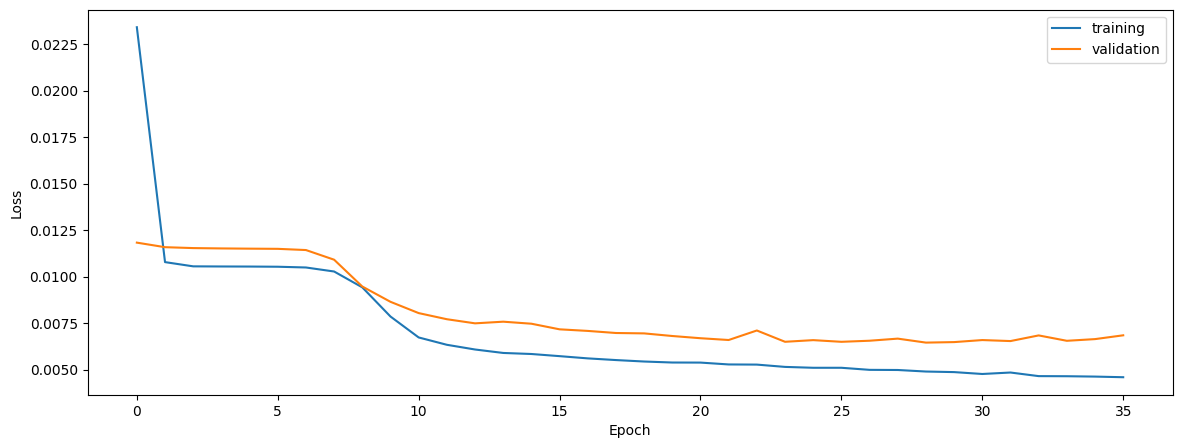

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


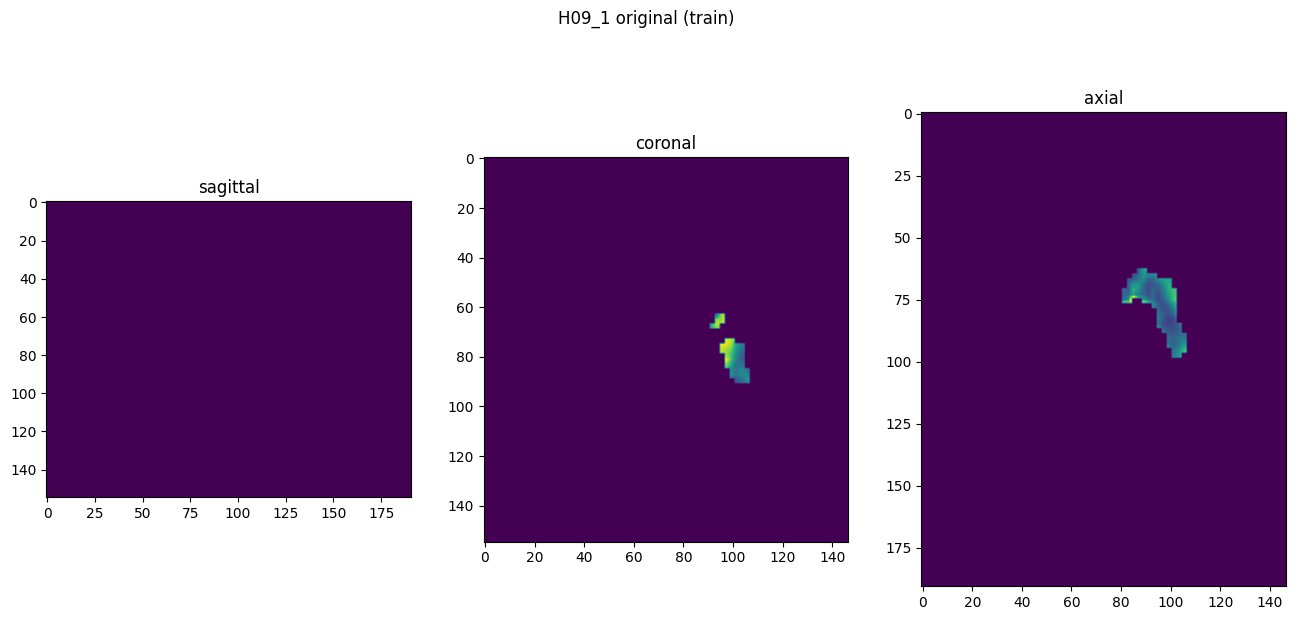

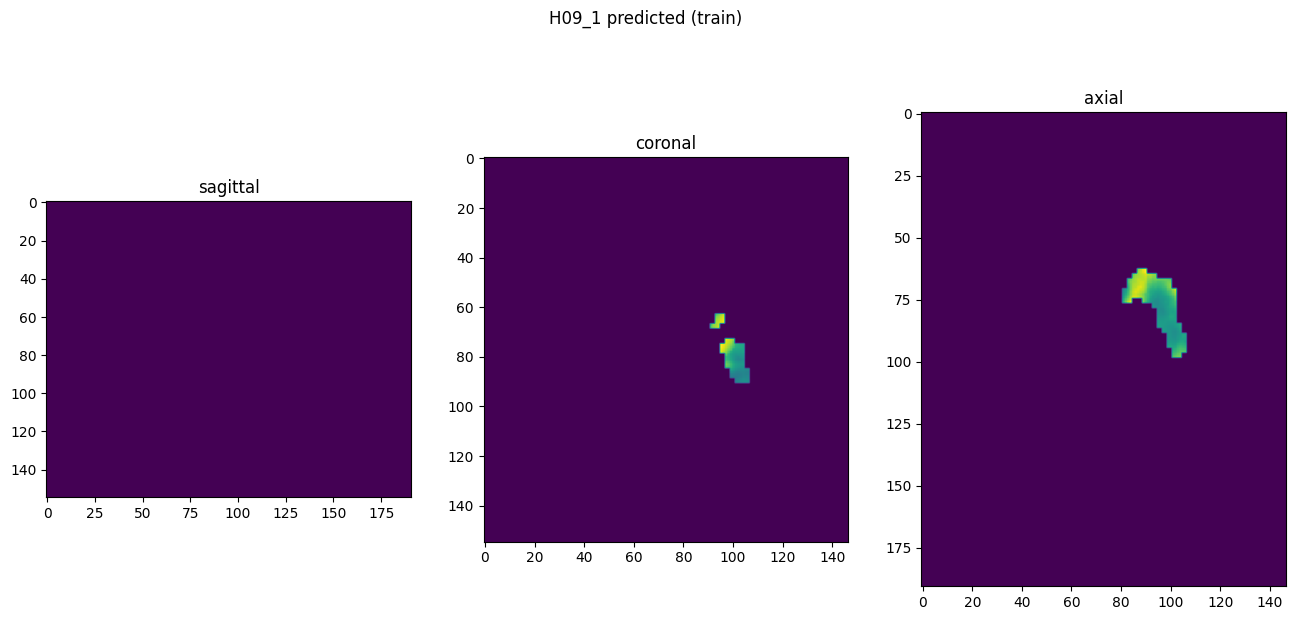

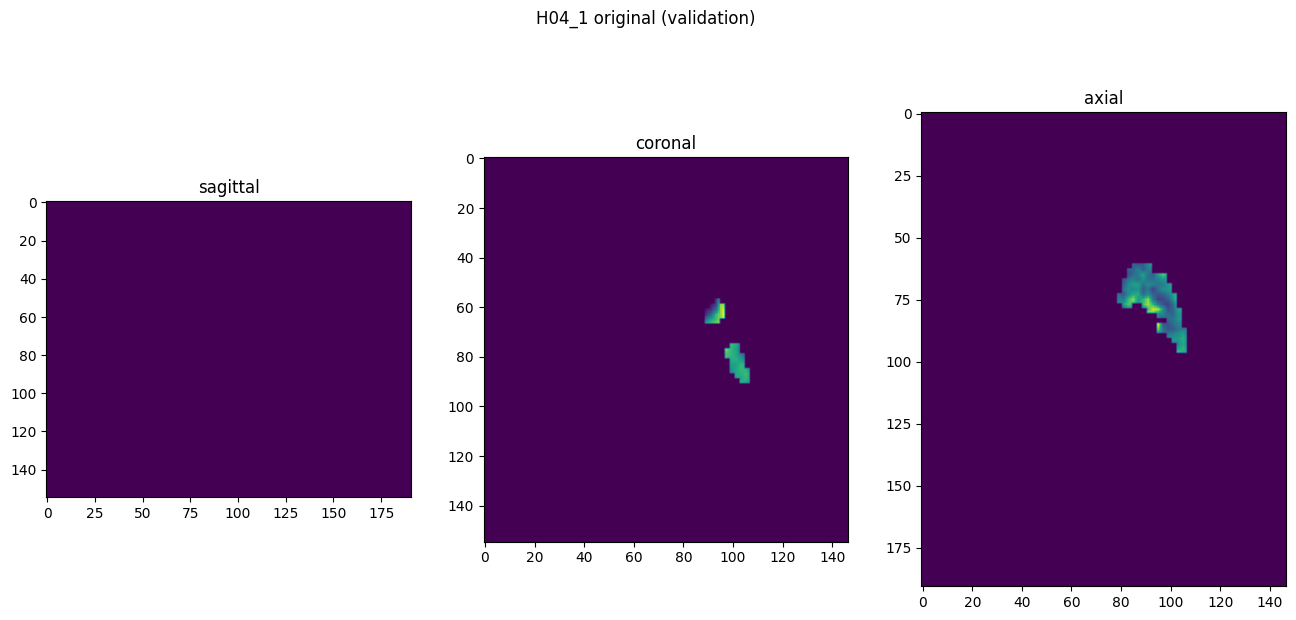

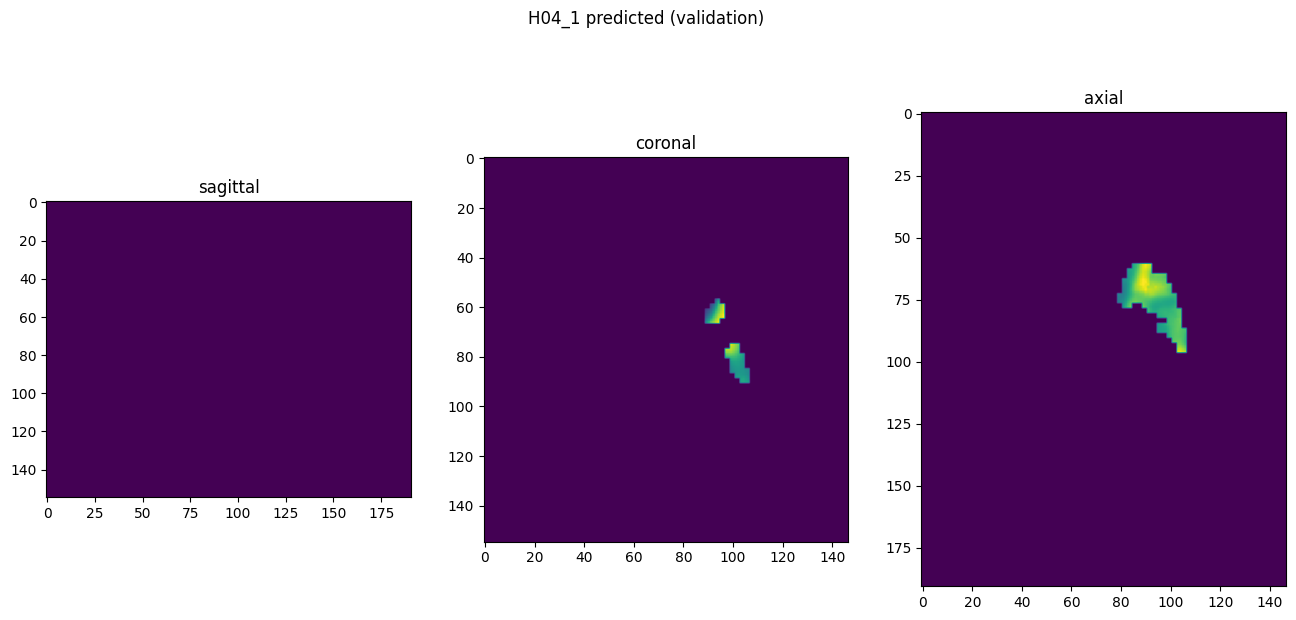

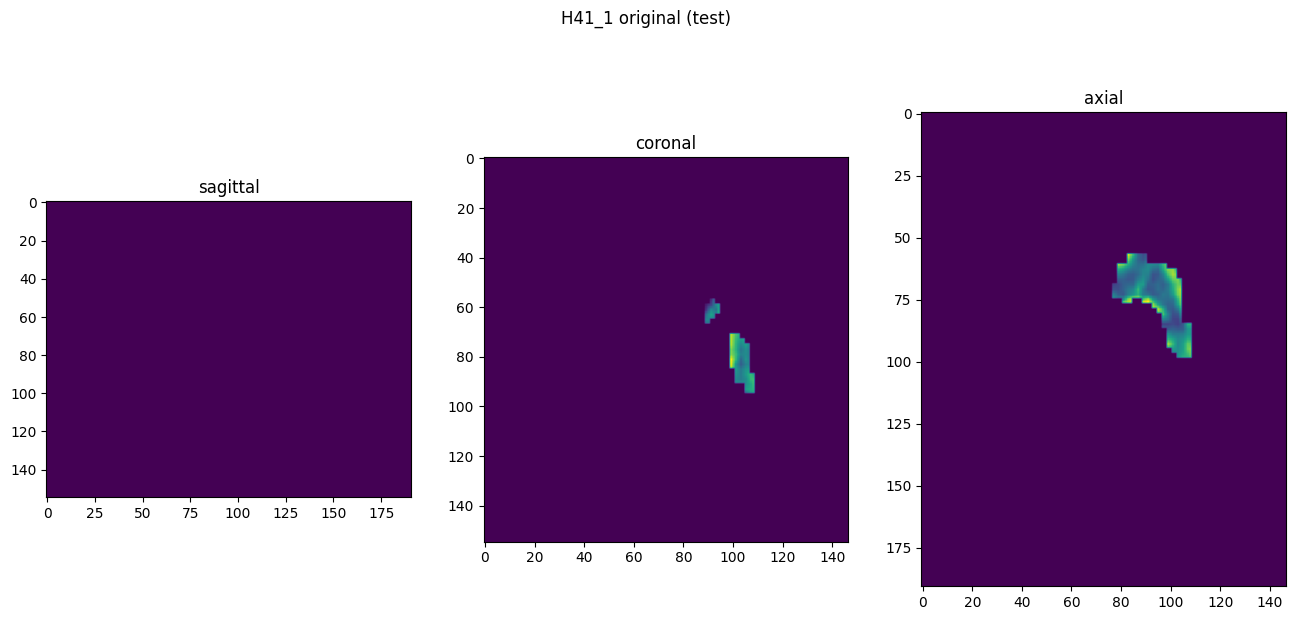

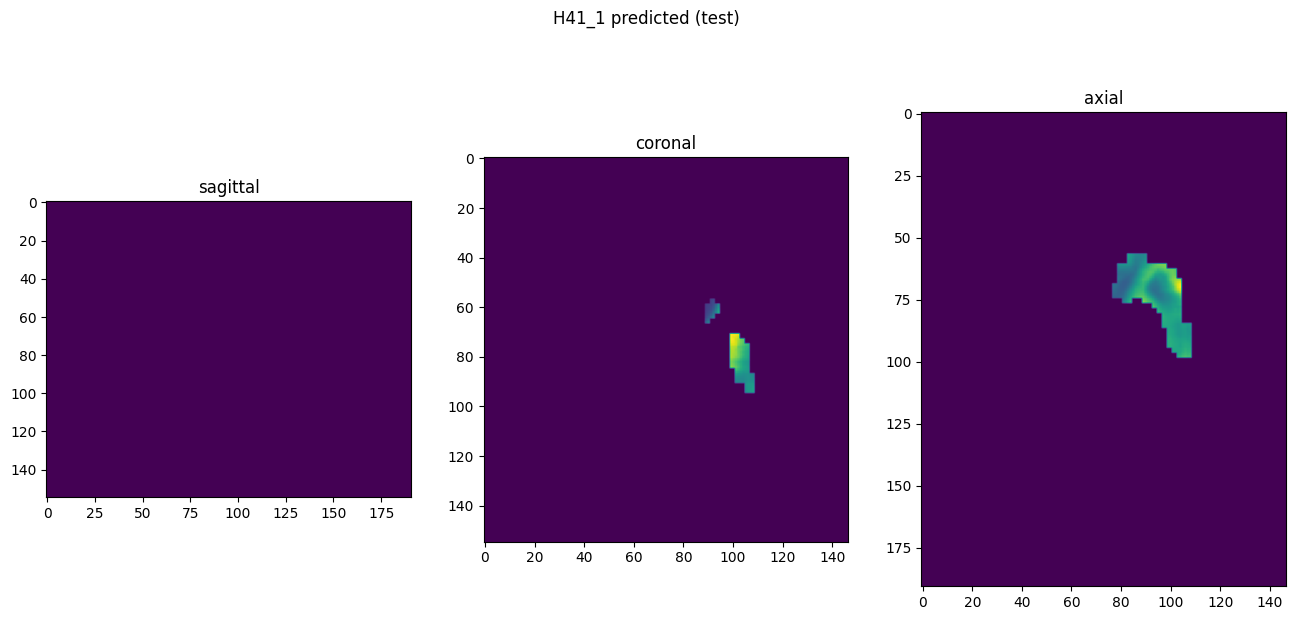

In [10]:
showResults(model, gen, threshold=None, background=False)